In [1]:
!nvidia-smi

Mon Aug 19 23:33:20 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.81                 Driver Version: 560.81         CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3080 Ti   WDDM  |   00000000:26:00.0  On |                  N/A |
| 49%   55C    P0            114W /  400W |    1340MiB /  12288MiB |      9%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## Import Depencies and read in the meta data

In [2]:
# Import Dependencies
import pandas as pd
import gradio as gr
import operator as op
from sklearn.model_selection import train_test_split
#from sklearn.metrics import balanced_accuracy_score
from transformers import pipeline
import gradio as gr
from PIL import Image
from sklearn.preprocessing import OneHotEncoder
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
import random

import numpy as np


In [3]:
# Reading the meta file containing all image file names
df = pd.read_csv("Resources/metadata.csv")
df


,imagefile,labelfile,target,train_id
0,Automatic Rifle_10.jpeg,Automatic Rifle_10.txt,0,1
1,Automatic Rifle_100.jpeg,Automatic Rifle_100.txt,0,1
2,Automatic Rifle_11.jpeg,Automatic Rifle_11.txt,0,1
3,Automatic Rifle_12.jpeg,Automatic Rifle_12.txt,0,1
4,Automatic Rifle_13.jpeg,Automatic Rifle_13.txt,0,0
...,...,...,...,...
709,Sword_95.jpeg,Sword_95.txt,8,1
710,Sword_96.jpeg,Sword_96.txt,8,0
711,Sword_97.jpeg,Sword_97.txt,8,1
712,Sword_98.jpeg,Sword_98.txt,8,1


In [4]:
# Split .txt and number
df[['weapon', 'weapon_id']] = df['labelfile']\
                                            .str.replace('.txt', '', regex=False)\
                                            .str.split('_', expand=True)
# Drop initial column 
len(df),df.head()

(714,
                   imagefile                labelfile  target  train_id  \
 0   Automatic Rifle_10.jpeg   Automatic Rifle_10.txt       0         1   
 1  Automatic Rifle_100.jpeg  Automatic Rifle_100.txt       0         1   
 2   Automatic Rifle_11.jpeg   Automatic Rifle_11.txt       0         1   
 3   Automatic Rifle_12.jpeg   Automatic Rifle_12.txt       0         1   
 4   Automatic Rifle_13.jpeg   Automatic Rifle_13.txt       0         0   
 
             weapon weapon_id  
 0  Automatic Rifle        10  
 1  Automatic Rifle       100  
 2  Automatic Rifle        11  
 3  Automatic Rifle        12  
 4  Automatic Rifle        13  )

In [5]:
# Build a list of imported images
base_path = "Resources/weapon_detection/train/images/"
images = []

for df_split in range(len(df)):
    filename = df.iloc[df_split,0]
    path = base_path + filename
    print(f'{df_split} of {len(df)}: Attempting to import {filename}')
    try:
        images.append(Image.open(path,formats=['jpeg']).convert('RGB'))
    except:
        print(f'FAILED: {filename}')

        
len(df),len(images),images

0 of 714: Attempting to import Automatic Rifle_10.jpeg
1 of 714: Attempting to import Automatic Rifle_100.jpeg
2 of 714: Attempting to import Automatic Rifle_11.jpeg
3 of 714: Attempting to import Automatic Rifle_12.jpeg
4 of 714: Attempting to import Automatic Rifle_13.jpeg
FAILED: Automatic Rifle_13.jpeg
5 of 714: Attempting to import Automatic Rifle_14.jpeg
6 of 714: Attempting to import Automatic Rifle_15.png
FAILED: Automatic Rifle_15.png
7 of 714: Attempting to import Automatic Rifle_16.png
FAILED: Automatic Rifle_16.png
8 of 714: Attempting to import Automatic Rifle_17.jpeg
9 of 714: Attempting to import Automatic Rifle_18.png
FAILED: Automatic Rifle_18.png
10 of 714: Attempting to import Automatic Rifle_19.jpeg
FAILED: Automatic Rifle_19.jpeg
11 of 714: Attempting to import Automatic Rifle_20.jpeg
12 of 714: Attempting to import Automatic Rifle_21.jpeg
13 of 714: Attempting to import Automatic Rifle_22.jpeg
14 of 714: Attempting to import Automatic Rifle_23.jpeg
15 of 714: Atte

(714,
 512,
 [<PIL.Image.Image image mode=RGB size=1280x720>,
  <PIL.Image.Image image mode=RGB size=1000x750>,
  <PIL.Image.Image image mode=RGB size=1920x1080>,
  <PIL.Image.Image image mode=RGB size=750x450>,
  <PIL.Image.Image image mode=RGB size=1280x720>,
  <PIL.Image.Image image mode=RGB size=1751x1110>,
  <PIL.Image.Image image mode=RGB size=1280x946>,
  <PIL.Image.Image image mode=RGB size=550x240>,
  <PIL.Image.Image image mode=RGB size=768x439>,
  <PIL.Image.Image image mode=RGB size=547x280>,
  <PIL.Image.Image image mode=RGB size=800x600>,
  <PIL.Image.Image image mode=RGB size=480x360>,
  <PIL.Image.Image image mode=RGB size=774x1080>,
  <PIL.Image.Image image mode=RGB size=907x382>,
  <PIL.Image.Image image mode=RGB size=1200x671>,
  <PIL.Image.Image image mode=RGB size=493x450>,
  <PIL.Image.Image image mode=RGB size=480x360>,
  <PIL.Image.Image image mode=RGB size=1500x1444>,
  <PIL.Image.Image image mode=RGB size=1500x600>,
  <PIL.Image.Image image mode=RGB size=1200x

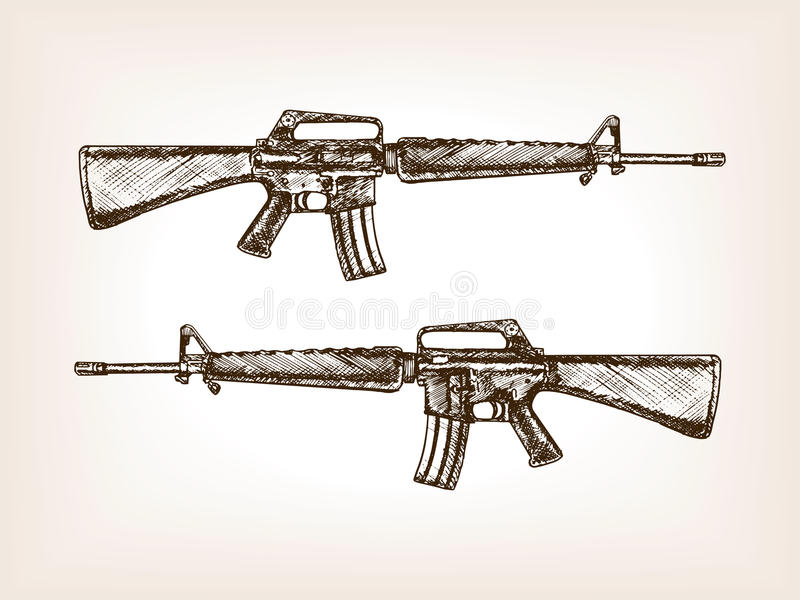

In [6]:
images[10]

In [7]:
substring = '.png'
filter = df['imagefile'].str.contains(substring)
df = df[~filter]
df

,imagefile,labelfile,target,train_id,weapon,weapon_id
0,Automatic Rifle_10.jpeg,Automatic Rifle_10.txt,0,1,Automatic Rifle,10
1,Automatic Rifle_100.jpeg,Automatic Rifle_100.txt,0,1,Automatic Rifle,100
2,Automatic Rifle_11.jpeg,Automatic Rifle_11.txt,0,1,Automatic Rifle,11
3,Automatic Rifle_12.jpeg,Automatic Rifle_12.txt,0,1,Automatic Rifle,12
4,Automatic Rifle_13.jpeg,Automatic Rifle_13.txt,0,0,Automatic Rifle,13
...,...,...,...,...,...,...
709,Sword_95.jpeg,Sword_95.txt,8,1,Sword,95
710,Sword_96.jpeg,Sword_96.txt,8,0,Sword,96
711,Sword_97.jpeg,Sword_97.txt,8,1,Sword,97
712,Sword_98.jpeg,Sword_98.txt,8,1,Sword,98


In [8]:
substring = '.jpg'
filter = df['imagefile'].str.contains(substring)
df = df[~filter]
df

,imagefile,labelfile,target,train_id,weapon,weapon_id
0,Automatic Rifle_10.jpeg,Automatic Rifle_10.txt,0,1,Automatic Rifle,10
1,Automatic Rifle_100.jpeg,Automatic Rifle_100.txt,0,1,Automatic Rifle,100
2,Automatic Rifle_11.jpeg,Automatic Rifle_11.txt,0,1,Automatic Rifle,11
3,Automatic Rifle_12.jpeg,Automatic Rifle_12.txt,0,1,Automatic Rifle,12
4,Automatic Rifle_13.jpeg,Automatic Rifle_13.txt,0,0,Automatic Rifle,13
...,...,...,...,...,...,...
709,Sword_95.jpeg,Sword_95.txt,8,1,Sword,95
710,Sword_96.jpeg,Sword_96.txt,8,0,Sword,96
711,Sword_97.jpeg,Sword_97.txt,8,1,Sword,97
712,Sword_98.jpeg,Sword_98.txt,8,1,Sword,98


In [9]:
# Remove files without images
df = df.loc[df['train_id'] != 0]
df

,imagefile,labelfile,target,train_id,weapon,weapon_id
0,Automatic Rifle_10.jpeg,Automatic Rifle_10.txt,0,1,Automatic Rifle,10
1,Automatic Rifle_100.jpeg,Automatic Rifle_100.txt,0,1,Automatic Rifle,100
2,Automatic Rifle_11.jpeg,Automatic Rifle_11.txt,0,1,Automatic Rifle,11
3,Automatic Rifle_12.jpeg,Automatic Rifle_12.txt,0,1,Automatic Rifle,12
5,Automatic Rifle_14.jpeg,Automatic Rifle_14.txt,0,1,Automatic Rifle,14
...,...,...,...,...,...,...
707,Sword_93.jpeg,Sword_93.txt,8,1,Sword,93
708,Sword_94.jpeg,Sword_94.txt,8,1,Sword,94
709,Sword_95.jpeg,Sword_95.txt,8,1,Sword,95
711,Sword_97.jpeg,Sword_97.txt,8,1,Sword,97


## Pre-process images to prep for splitting into training and testing data

In [10]:
# Check all the sizes into a list, then convert to a set
sizes = set([img.size for img in images])
sizes

{(220, 140),
 (250, 200),
 (260, 280),
 (270, 323),
 (283, 879),
 (295, 280),
 (300, 200),
 (315, 681),
 (320, 320),
 (334, 500),
 (351, 500),
 (354, 500),
 (355, 239),
 (355, 282),
 (355, 355),
 (364, 280),
 (390, 280),
 (400, 400),
 (416, 280),
 (420, 368),
 (425, 425),
 (433, 537),
 (440, 440),
 (462, 280),
 (480, 360),
 (481, 280),
 (493, 450),
 (498, 500),
 (498, 1024),
 (500, 333),
 (500, 344),
 (500, 500),
 (509, 330),
 (509, 360),
 (509, 680),
 (520, 280),
 (522, 560),
 (539, 280),
 (540, 360),
 (547, 280),
 (550, 240),
 (550, 422),
 (562, 746),
 (563, 1000),
 (569, 569),
 (586, 360),
 (590, 393),
 (600, 256),
 (600, 300),
 (600, 338),
 (600, 420),
 (600, 472),
 (600, 600),
 (600, 947),
 (604, 340),
 (616, 353),
 (620, 350),
 (621, 414),
 (626, 352),
 (626, 469),
 (638, 320),
 (640, 426),
 (648, 432),
 (650, 650),
 (660, 660),
 (672, 280),
 (676, 357),
 (680, 453),
 (700, 178),
 (703, 280),
 (720, 405),
 (720, 483),
 (728, 410),
 (736, 736),
 (736, 1079),
 (750, 450),
 (750, 75

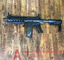

In [11]:
# Use a for loop to resize all images to 64 by 60
target_size = (64, 60)

resized_images = [img.resize(target_size, resample = Image.LANCZOS) for img in images]
resized_images[1]

In [12]:
# Check images resizing
sizes = set([img.size for img in resized_images])
sizes

{(64, 60)}

In [13]:
# Convert all images to floating point numpy arrays
float_images = [np.array(img).astype(np.float32) for img in resized_images]

print("Pixel Values:")
print(float_images[0])


Pixel Values:
[[[173. 141. 102.]
  [176. 145. 106.]
  [177. 147. 108.]
  ...
  [161. 133.  98.]
  [161. 132.  98.]
  [159. 131.  96.]]

 [[172. 143. 104.]
  [176. 146. 107.]
  [178. 148. 108.]
  ...
  [162. 133.  98.]
  [162. 133.  99.]
  [160. 132.  97.]]

 [[174. 146. 106.]
  [177. 148. 109.]
  [179. 149. 109.]
  ...
  [164. 135. 101.]
  [162. 134.  99.]
  [162. 133.  97.]]

 ...

 [[187. 160. 121.]
  [187. 162. 121.]
  [186. 159. 120.]
  ...
  [186. 163. 125.]
  [184. 161. 125.]
  [185. 163. 126.]]

 [[189. 162. 124.]
  [188. 162. 122.]
  [187. 159. 121.]
  ...
  [185. 161. 125.]
  [186. 163. 126.]
  [185. 163. 125.]]

 [[189. 162. 123.]
  [188. 160. 123.]
  [189. 161. 122.]
  ...
  [184. 161. 125.]
  [185. 161. 124.]
  [184. 162. 125.]]]


In [14]:
# normalize images to a range between 0 and 1 by
# dividing all pixel values by the max of 255

normalized_images = [img/255 for img in float_images]

# Display the pixel values 
print("Pixel Values:")
print(normalized_images[0].shape)
print(normalized_images[0])


Pixel Values:
(60, 64, 3)
[[[0.6784314  0.5529412  0.4       ]
  [0.6901961  0.5686275  0.41568628]
  [0.69411767 0.5764706  0.42352942]
  ...
  [0.6313726  0.52156866 0.38431373]
  [0.6313726  0.5176471  0.38431373]
  [0.62352943 0.5137255  0.3764706 ]]

 [[0.6745098  0.56078434 0.40784314]
  [0.6901961  0.57254905 0.41960785]
  [0.69803923 0.5803922  0.42352942]
  ...
  [0.63529414 0.52156866 0.38431373]
  [0.63529414 0.52156866 0.3882353 ]
  [0.627451   0.5176471  0.38039216]]

 [[0.68235296 0.57254905 0.41568628]
  [0.69411767 0.5803922  0.42745098]
  [0.7019608  0.58431375 0.42745098]
  ...
  [0.6431373  0.5294118  0.39607844]
  [0.63529414 0.5254902  0.3882353 ]
  [0.63529414 0.52156866 0.38039216]]

 ...

 [[0.73333335 0.627451   0.4745098 ]
  [0.73333335 0.63529414 0.4745098 ]
  [0.7294118  0.62352943 0.47058824]
  ...
  [0.7294118  0.6392157  0.49019608]
  [0.72156864 0.6313726  0.49019608]
  [0.7254902  0.6392157  0.49411765]]

 [[0.7411765  0.63529414 0.4862745 ]
  [0.737254

In [15]:
for i in range(len(normalized_images)):
    print(normalized_images[0].shape)

(60, 64, 3)
(60, 64, 3)
(60, 64, 3)
(60, 64, 3)
(60, 64, 3)
(60, 64, 3)
(60, 64, 3)
(60, 64, 3)
(60, 64, 3)
(60, 64, 3)
(60, 64, 3)
(60, 64, 3)
(60, 64, 3)
(60, 64, 3)
(60, 64, 3)
(60, 64, 3)
(60, 64, 3)
(60, 64, 3)
(60, 64, 3)
(60, 64, 3)
(60, 64, 3)
(60, 64, 3)
(60, 64, 3)
(60, 64, 3)
(60, 64, 3)
(60, 64, 3)
(60, 64, 3)
(60, 64, 3)
(60, 64, 3)
(60, 64, 3)
(60, 64, 3)
(60, 64, 3)
(60, 64, 3)
(60, 64, 3)
(60, 64, 3)
(60, 64, 3)
(60, 64, 3)
(60, 64, 3)
(60, 64, 3)
(60, 64, 3)
(60, 64, 3)
(60, 64, 3)
(60, 64, 3)
(60, 64, 3)
(60, 64, 3)
(60, 64, 3)
(60, 64, 3)
(60, 64, 3)
(60, 64, 3)
(60, 64, 3)
(60, 64, 3)
(60, 64, 3)
(60, 64, 3)
(60, 64, 3)
(60, 64, 3)
(60, 64, 3)
(60, 64, 3)
(60, 64, 3)
(60, 64, 3)
(60, 64, 3)
(60, 64, 3)
(60, 64, 3)
(60, 64, 3)
(60, 64, 3)
(60, 64, 3)
(60, 64, 3)
(60, 64, 3)
(60, 64, 3)
(60, 64, 3)
(60, 64, 3)
(60, 64, 3)
(60, 64, 3)
(60, 64, 3)
(60, 64, 3)
(60, 64, 3)
(60, 64, 3)
(60, 64, 3)
(60, 64, 3)
(60, 64, 3)
(60, 64, 3)
(60, 64, 3)
(60, 64, 3)
(60, 64, 3)
(60,

In [16]:
df['weapon'].unique()

array(['Automatic Rifle', 'Bazooka', 'Grenade Launcher', 'Handgun',
       'Knife', 'Shotgun', 'SMG', 'Sniper', 'Sword'], dtype=object)

In [17]:
df

,imagefile,labelfile,target,train_id,weapon,weapon_id
0,Automatic Rifle_10.jpeg,Automatic Rifle_10.txt,0,1,Automatic Rifle,10
1,Automatic Rifle_100.jpeg,Automatic Rifle_100.txt,0,1,Automatic Rifle,100
2,Automatic Rifle_11.jpeg,Automatic Rifle_11.txt,0,1,Automatic Rifle,11
3,Automatic Rifle_12.jpeg,Automatic Rifle_12.txt,0,1,Automatic Rifle,12
5,Automatic Rifle_14.jpeg,Automatic Rifle_14.txt,0,1,Automatic Rifle,14
...,...,...,...,...,...,...
707,Sword_93.jpeg,Sword_93.txt,8,1,Sword,93
708,Sword_94.jpeg,Sword_94.txt,8,1,Sword,94
709,Sword_95.jpeg,Sword_95.txt,8,1,Sword,95
711,Sword_97.jpeg,Sword_97.txt,8,1,Sword,97


In [18]:
# Set X and y values
X = normalized_images
y = df['weapon']
# Check value lengths for X and y variables
len(X),len(y)
X[0].shape

(60, 64, 3)

In [19]:
y.nunique()

9

In [20]:
# Convert values to numpy arrays

y = np.array(y)
X = np.array(X)

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y)


## Augment to get more samples

In [22]:
# Apply augmentation to the whole training dataset
# Define the augmentation pipeline
augmentation_model = tf.keras.Sequential([
    tf.keras.layers.RandomRotation(0.2),         
    tf.keras.layers.RandomTranslation(0.1, 0.1),
    tf.keras.layers.RandomZoom(0.2),            
    tf.keras.layers.RandomFlip('horizontal')     
])


In [23]:

# Create variables to hold the X and y training data
X_train_aug = []
y_train_aug = []

# Loop through all the images
for i in range(len(X_train)):
    # Select the image
    img = X_train[i]
    # Select the label from the training data
    label = y_train[i]
    
    ## Add a channel dimension for grayscale images
    img = np.expand_dims(img, axis=0)  
    
    ## Ensure that the input data has the correct shape
    #img = np.expand_dims(img, axis=-1) 
    
    # Add 5 images for every original image
    for j in range(25):
        # Append a new image to the X list
        X_train_aug.append(augmentation_model(img, training=True)[0].numpy())
        #print(X_train_aug[0].shape)
        
        # Append the label for the original image to the y list
        y_train_aug.append(label)

# Print the length of each list
print(len(X_train_aug))
print(len(y_train_aug))
X_train_aug[0].shape

(60, 64, 3)

In [24]:
# Reshape test data for the model
X_test_np = []
for img in X_test:
    
    # Append the image to the list
    X_test_np.append(img)

# Convert to numpy array
X_test_np = np.array(X_test_np)

# Check the shape of the first image
X_test_np[0].shape

(60, 64, 3)

In [25]:
# One hot encode the y data
y_encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False).fit(np.array(y_train_aug).reshape(-1, 1))
y_train_aug_enc = y_encoder.transform(np.array(y_train_aug).reshape(-1, 1))
y_test_enc = y_encoder.transform(np.array(y_test).reshape(-1, 1))

# Convert values to numpy arrays
X_train_aug_np = np.array(X_train_aug)
X_test_np = np.array(X_test_np)
y_train_aug_np = np.array(y_train_aug_enc)
y_test_np = np.array(y_test_enc)

# Split the training dataset into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_aug_np, y_train_aug_np, test_size=0.2, random_state=42)

# Print the total number of one_hot_encoded columns
np.array(y_train).shape,X_train[0].shape

((7680, 9), (60, 64, 3))

## Create a CNN model

In [26]:
# Define a CNN model
model = keras.Sequential([
    layers.Conv2D(256, (3, 3), activation='relu', input_shape=(60, 64, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(90, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(36, (3, 3), activation='relu'),
    layers.Flatten(),
    layers.Dense(27, activation='relu'),
    #layers.Dense(18, activation='relu'),
    #layers.Dense(27, activation='relu'),
    layers.Dense(18, activation='relu'),
    layers.Dense(9, activation='softmax') 
])


c:\Users\nick\.conda\envs\dev\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [27]:

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [28]:

# Train the model
batch_size = 25
epochs = 50
history = model.fit(
    X_train, y_train,
    validation_data=(X_val,y_val),
    epochs=epochs
)

Epoch 1/50
240/240 ━━━━━━━━━━━━━━━━━━━━ 45s 181ms/step - accuracy: 0.1330 - loss: 2.1875 - val_accuracy: 0.1505 - val_loss: 2.1603
Epoch 2/50
240/240 ━━━━━━━━━━━━━━━━━━━━ 46s 190ms/step - accuracy: 0.1688 - loss: 2.1313 - val_accuracy: 0.2385 - val_loss: 2.0319
Epoch 3/50
240/240 ━━━━━━━━━━━━━━━━━━━━ 44s 181ms/step - accuracy: 0.2637 - loss: 1.9604 - val_accuracy: 0.3167 - val_loss: 1.8153
Epoch 4/50
240/240 ━━━━━━━━━━━━━━━━━━━━ 46s 192ms/step - accuracy: 0.3302 - loss: 1.7885 - val_accuracy: 0.3495 - val_loss: 1.7003
Epoch 5/50
240/240 ━━━━━━━━━━━━━━━━━━━━ 54s 224ms/step - accuracy: 0.3801 - loss: 1.6595 - val_accuracy: 0.3859 - val_loss: 1.6186
Epoch 6/50
240/240 ━━━━━━━━━━━━━━━━━━━━ 47s 195ms/step - accuracy: 0.4295 - loss: 1.5177 - val_accuracy: 0.4464 - val_loss: 1.4901
Epoch 7/50
240/240 ━━━━━━━━━━━━━━━━━━━━ 44s 185ms/step - accuracy: 0.4904 - loss: 1.3807 - val_accuracy: 0.5000 - val_loss: 1.3839
Epoch 8/50
240/240 ━━━━━━━━━━━━━━━━━━━━ 45s 189ms/step - accuracy: 0.5443 - loss: 1

try 50 epochs 25 batch size & 38 epochs 25 batch

In [29]:
# Evaluate the model using the testing data
model.evaluate(X_test_np, y_test_np)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.4719 - loss: 7.6825


[8.026322364807129, 0.453125]

In [30]:
import pickle

# save the iris classification model as a pickle file
model_pkl = "pew_pew_pew_model.pkl"  

with open(model_pkl, 'wb') as file:  
    pickle.dump(model, file)

In [31]:
# Train the model
batch_size = 800
epochs = 25
history = model.fit(
    X_train, y_train,
    validation_data=(X_val,y_val),
    epochs=epochs
)

Epoch 1/25
240/240 ━━━━━━━━━━━━━━━━━━━━ 46s 192ms/step - accuracy: 0.9600 - loss: 0.1482 - val_accuracy: 0.7948 - val_loss: 1.2037
Epoch 2/25
240/240 ━━━━━━━━━━━━━━━━━━━━ 47s 196ms/step - accuracy: 0.9777 - loss: 0.1026 - val_accuracy: 0.8208 - val_loss: 0.8987
Epoch 3/25
177/240 ━━━━━━━━━━━━━━━━━━━━ 11s 177ms/step - accuracy: 0.9705 - loss: 0.0956

In [ ]:
# Evaluate the model using the testing data
model.evaluate(X_test_np, y_test_np)

In [ ]:
#def sepia(input_img):
#    sepia_filter = np.array([
#        [0.393, 0.769, 0.189],
#        [0.349, 0.686, 0.168],
#        [0.272, 0.534, 0.131]
#    ])
#    sepia_img = input_img.dot(sepia_filter.T)
#    sepia_img /= sepia_img.max()
#    return sepia_img
#
#demo = gr.Interface(sepia, gr.Image(), "image")
#demo.launch()

In [ ]:
import pickle

# save the iris classification model as a pickle file
model_pkl = "pew_pew_pew_model_2.pkl"  

with open(model_pkl, 'wb') as file:  
    pickle.dump(model, file)

In [ ]:
# saving model to use later

# to load in    
# load model from pickle file
with open(model_pkl, 'rb') as file:  
model = pickle.load(file)  

## evaluate model 
#y_predict = model.predict(X_test)  

## check results
#print(classification_report(y_test, y_predict)) 

In [ ]:
# Train the model
batch_size = 80
epochs = 800
history = model.fit(
    X_train, y_train,
    validation_data=(X_val,y_val),
    epochs=epochs
)

In [ ]:
# Evaluate the model using the testing data
model.evaluate(X_test_np, y_test_np)